In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
import random

from tqdm import tqdm

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, GroupKFold

In [2]:
def score_predict(X_test, y_test, pred):

    df = X_test.copy()
    df['true_y'] = y_test
    df['pred_y'] = pred

    match = sum((df.groupby('srch_id')['true_y'].idxmax() == df.groupby('srch_id')['pred_y'].idxmax()) & (df.groupby('srch_id')['true_y'].max() > 1))

    score = match / df['srch_id'].nunique()
    return score

In [3]:
data = pd.read_csv('data/training_set_VU_DM.csv')
data.drop('date_time', axis = 1, inplace=True)

# data = pd.read_csv('data/FE_training_set.csv')
# data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# data['target'] = 5* data['booking_bool'] + data['click_bool']
# data['true_rank'] = data['target']


# #data['target'] = data['booking_bool'] + data['click_bool'] + (1-data['random_bool']) * (1-data['booking_bool']) * (41 - data['position']) / 40
# data['target'].loc[data['target'].isna()] = int(0)
# #data['target'] = data['target'].astype(int)

In [5]:
# target including average booking

data['true_rank'] = data['click_bool'] + 4* data['booking_bool']


# data = data.join(data.groupby('prop_id')['booking_bool'].mean(), on = 'prop_id', rsuffix = '_mean')
# data = data.join(data.groupby('prop_id')['click_bool'].mean(), on = 'prop_id', rsuffix = '_mean')

data['target'] = data['true_rank']
# data['target'] =  (5* data['booking_bool'] + 1* data['booking_bool_mean'] + 1 * data['click_bool'] + 0.2* data['click_bool_mean']) * (5/7.2)

data['target'].loc[data['target'].isna()] = int(0)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_67597/3256955560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].loc[data['target'].isna()] = int(0)


In [6]:
# data['target'] = 1* data['booking_bool'] + data['click_bool']
# data['target'].loc[data['target'].isna()] = int(0)
# data['target'] = data['target'].astype(int)

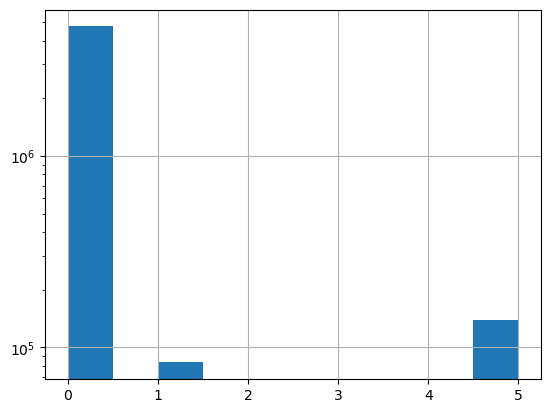

In [7]:
data['target'].hist()
plt.yscale('log')

In [8]:
# get search ids with any booking
ids = data['srch_id'].loc[data['booking_bool'] == 1].unique()

In [9]:
# use only the searches that resulted in a booking
data = data.loc[data['srch_id'].isin(ids)]

In [10]:
train_ids = random.sample(list(ids), k = int(0.8* len(ids)))
test_ids = set(ids) - set(train_ids)

In [11]:
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['booking_bool'].mean(), on = 'prop_id', rsuffix = '_mean')
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['click_bool'].mean(), on = 'prop_id', rsuffix = '_mean')

In [12]:
data.loc[data['srch_id'] == list(test_ids)[0]]

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,true_rank,target
60,6,14,100,NaN,NaN,100,10759,0,2.0,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
61,6,14,100,NaN,NaN,100,22135,0,5.0,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
62,6,14,100,NaN,NaN,100,52376,2,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
63,6,14,100,NaN,NaN,100,104251,3,4.0,1,...,NaN,NaN,NaN,NaN,NaN,1,162.38,1,5,5
64,6,14,100,NaN,NaN,100,118866,2,4.5,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0


In [13]:
train_data = data.loc[data['srch_id'].isin(train_ids)]
test_data = data.loc[data['srch_id'].isin(test_ids)]

In [14]:
#undersample non bookings
X_under, y_under = resample(train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[train_data['target'] < 1], train_data['target'].loc[train_data['target'] < 1]
                                      , n_samples= 2* sum(data['target'] >= 1), replace=False)

In [15]:
X_bal = pd.concat([X_under, train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[train_data['target'] >= 1]])

y_bal = y_under
y_bal = y_bal.append(train_data['target'].loc[train_data['target'] >= 1])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_67597/2782943548.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_bal = y_bal.append(train_data['target'].loc[train_data['target'] >= 1])


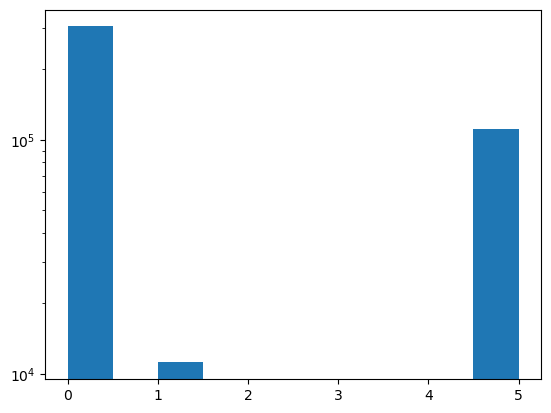

In [16]:
plt.hist(y_bal)
plt.yscale('log')

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)

# X_train, X_test, y_train, y_test = train_test_split(data.drop(['booking_bool_mean', 'click_bool_mean', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                        , axis=1), data['target'])
#X_train, y_train = X_bal, y_bal

In [18]:
# much better than just replacing with 0
# X_train = X_train.fillna(-9999)
# baseline = GradientBoostingRegressor(n_estimators = 100, max_leaf_nodes=None, max_depth=3, random_state=42)

baseline = HistGradientBoostingRegressor(random_state=42)


In [19]:
# hyper param tuning
# param_dist = {'min_samples_split' : [2, 10_000], 'max_depth' : [3, 15]}
# hp_search = HalvingRandomSearchCV(baseline, param_dist, min_resources=50_000).fit(X_train, y_train)

In [20]:
# hp_search.best_params_

In [21]:
baseline.fit(X_bal.drop(['srch_id'], axis = 1),y_bal)

HistGradientBoostingRegressor(random_state=42)

In [22]:
# pred = baseline.predict(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [23]:
#mean_squared_error(data['target'], pred)

In [24]:
# pred_test = baseline.predict(X_test.drop(['srch_id'], axis=1).fillna(-9999))
# print('MSE', mean_squared_error(y_test, pred_test))

# score = score_predict(X_test, y_test, pred_test)
# print('score', score)

In [25]:
test_data['pred_score'] = baseline.predict(test_data.drop(['true_rank', 'srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1))

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_67597/957892389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_score'] = baseline.predict(test_data.drop(['true_rank', 'srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']


In [26]:
set(baseline.feature_names_in_) - set(test_data.columns)

set()

In [27]:
print('MSE', mean_squared_error(test_data['target'], test_data['pred_score']))

MSE 2.095547807597489


In [28]:
test_data['pred_rank'] = test_data.groupby('srch_id')['pred_score'].rank(ascending=False).astype(int)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_67597/452043351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_rank'] = test_data.groupby('srch_id')['pred_score'].rank(ascending=False).astype(int)


In [29]:
# scoring with ndcg
mean_ndcg = 0
counter = 0
for id in tqdm(test_ids):
    ndcg = ndcg_score([test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy()],
                      [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

    mean_ndcg += ndcg
    if ndcg < 1.0:
        counter +=1

mean_ndcg = mean_ndcg/len(test_ids)

100%|██████████| 27678/27678 [00:20<00:00, 1340.17it/s]


In [30]:
mean_ndcg

0.3806465856507293

In [31]:
id = list(test_ids)[8]
print(test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy())
print(test_data['pred_rank'].loc[test_data['srch_id'] == id].to_numpy())
ndcg_score([test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy()], [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 7 26  8  6 19 17 12 27 21 16  4 14 22 10 24 23  1  3 25 11  5 15 18 20
  9 13  2]


0.0

In [32]:
id = list(test_ids)[9]

test_data[['true_rank', 'pred_score', 'pred_rank']].loc[test_data['srch_id'] == id].head(20)

,true_rank,pred_score,pred_rank
3905986,0,0.547902,22
3905987,0,2.426047,1
3905988,0,1.881257,9
3905989,0,0.514299,26
3905990,0,1.382216,14
3905991,0,1.124190,16
3905992,0,0.537984,24
3905993,0,0.543214,23
3905994,0,2.000848,6
3905995,0,2.263121,3


## Predict the test dataset and bring it into requested format

In [36]:
# test_data = pd.read_csv('data/FE_test_set.csv')
# test_data.drop('Unnamed: 0', axis=1, inplace=True)

test_data = pd.read_csv('data/test_set_VU_DM.csv')
test_data.drop('date_time', axis = 1, inplace=True)

In [37]:
test_data.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,24,216,NaN,NaN,219,3180,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24,216,NaN,NaN,219,5543,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,24,216,NaN,NaN,219,14142,2,3.5,1,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,24,216,NaN,NaN,219,22393,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,24,216,NaN,NaN,219,24194,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
test_data['prediction'] = baseline.predict(test_data.drop(['srch_id'], axis=1).fillna(-9999))

# test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'date_time'], axis=1).fillna(-9999))

In [39]:
# sort values for final format
test_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [40]:
filename = 'data/predictions/prediction'+str(datetime.now())+'.csv'
test_data[['srch_id', 'prop_id']].to_csv(filename, index=False)